In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import pyro
import pyro.distributions as dist
from pyro.distributions import Categorical, Normal, Multinomial, Binomial, MultivariateNormal, Beta
from pyro.distributions.torch import Bernoulli
from pyro.distributions import constraints
import pyro.infer as infer



/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Linear Data

In [2]:
nsamples = 1000
seed = 659983
torch.manual_seed(seed)
np.random.seed(seed)
pyro.set_rng_seed(seed)

In [3]:
x = torch.empty(nsamples).uniform_(0, 6)
y = torch.zeros(nsamples)
nsample1 = int(0.15 * nsamples)
nsample2 = nsamples - nsample1

idx = torch.randperm(nsamples)[:nsample1]
flag = torch.zeros(nsamples)
flag[idx] = 1.
coef1 = torch.normal(2.5, 0.8, (nsamples,))
coef2 = torch.normal(-2.5, 1.2, (nsamples,))
# b1 = -5
# b2 = 10
b = 2
y = b + x * coef1 * flag + x * coef2 * (1 - flag)

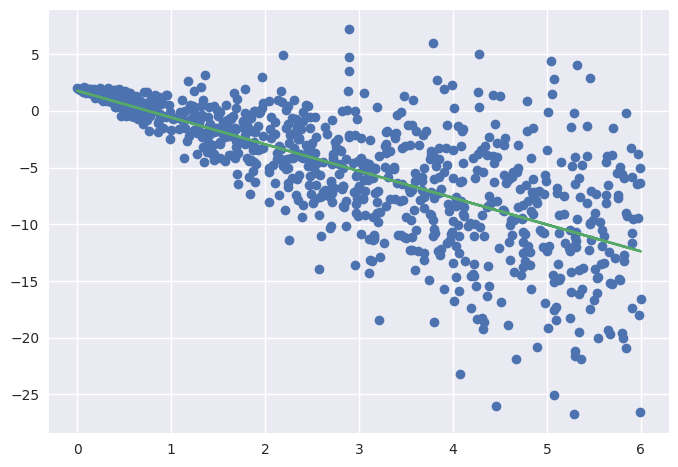

In [4]:
fig, ax = plt.subplots()
x_plot = x[flag == 0].numpy()
y_plot = y[flag == 0].numpy()
ax.plot(x_plot, y_plot, "o")
reg = scipy.stats.linregress(x_plot, y_plot)
ax.plot(x_plot, reg.slope * x_plot + reg.intercept)

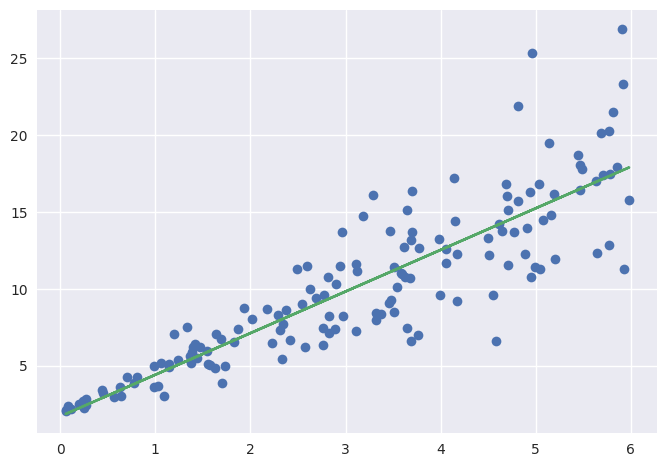

In [5]:
fig, ax = plt.subplots()
x_plot = x[flag == 1].numpy()
y_plot = y[flag == 1].numpy()
ax.plot(x_plot, y_plot, "o")
reg = scipy.stats.linregress(x_plot, y_plot)
ax.plot(x_plot, reg.slope * x_plot + reg.intercept)

## Model 

In [6]:
def model(x, flag, obs):
    beta = pyro.sample("beta", dist.Normal(0, 10.))
    c1 = pyro.sample("c1",  dist.Normal(0., 1.))
    c2 = pyro.sample("c2",  dist.Normal(0., 1.))
    sigma = pyro.sample("sigma",dist.Uniform(0, 10.))
    mean = beta + x * c1 * flag + x * c2 * (1 - flag)
    with pyro.plate("model_plate_reg", len(x)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=obs)

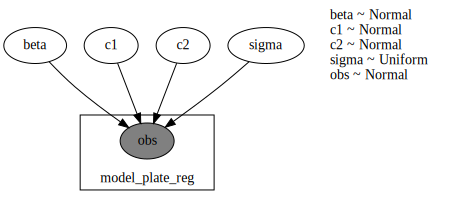

In [7]:
pyro.render_model(model, (x, flag, y), render_distributions=True)

In [8]:
# pyro.clear_param_store()

In [9]:
def guide(x, flag, obs):
    beta_loc = pyro.param("beta_loc", lambda: torch.tensor(0.))
    beta_scale = pyro.param("beta_scale", lambda: torch.tensor(1.), constraint=constraints.positive)
    
    sigma_loc = pyro.param("sigma_loc", lambda: torch.tensor(1.), constraint=constraints.positive)
    
    weights_loc = pyro.param("weights_loc", lambda: torch.randn(2))
    weights_scale = pyro.param("weights_scale", lambda: torch.ones(2), constraint=constraints.positive)
    
    beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale))
    c1 = pyro.sample("c1",  dist.Normal(weights_loc[0], weights_scale[0]))
    c2 = pyro.sample("c2",  dist.Normal(weights_loc[1], weights_scale[1]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, 0.05))
    
    return {"beta": beta, "sigma": sigma, "c1": c1, "c2": c2}

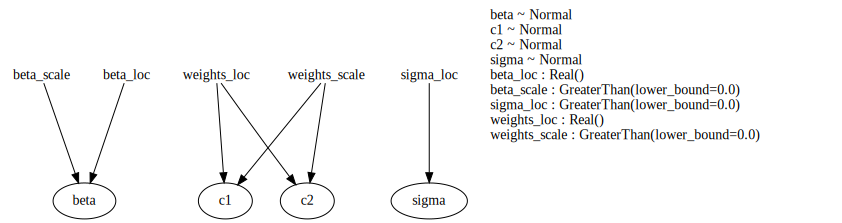

In [10]:
pyro.render_model(guide, (x, flag, y), render_distributions=True, render_params=True)

In [11]:
pyro.clear_param_store()
adam = pyro.optim.Adam({"lr": 0.008,})
elbo = infer.Trace_ELBO()
svi = infer.SVI(model, guide, adam, elbo)
losses = []
for i in range(2500):
    loss = svi.step(x, flag, y)
    losses.append(loss)
    

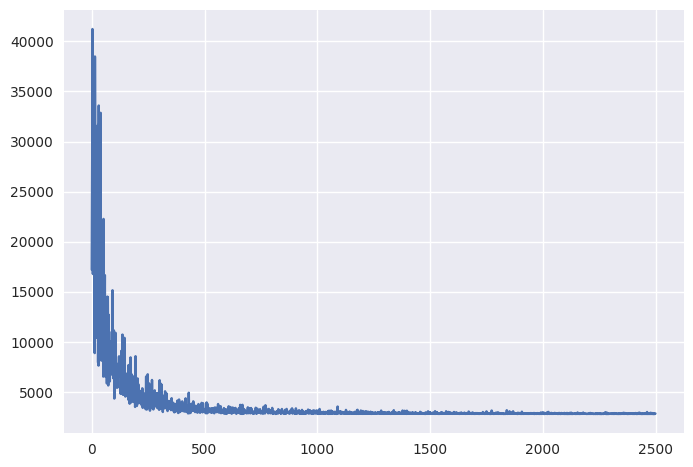

In [12]:
plt.plot(losses)

In [13]:
for name, value in pyro.get_param_store().items():
    print(f'{name} -> {value}')

beta_loc -> 1.2143055200576782
beta_scale -> 0.30970117449760437
sigma_loc -> 4.044930934906006
weights_loc -> tensor([ 2.7484, -2.1884], requires_grad=True)
weights_scale -> tensor([0.3563, 0.2432], grad_fn=<AddBackward0>)


In [14]:
with pyro.plate("samples", 800):
    samples = guide(x, flag, y)

In [15]:
samples.keys()

dict_keys(['beta', 'sigma', 'c1', 'c2'])

(array([ 1.,  0.,  0.,  4.,  4.,  5.,  5.,  8., 11., 16., 16., 12., 15.,
        30., 29., 40., 35., 45., 45., 60., 47., 48., 47., 41., 49., 32.,
        24., 27., 21., 27., 13., 13., 11.,  9.,  1.,  2.,  3.,  3.,  0.,
         1.]),
 array([0.2169739 , 0.26560563, 0.31423739, 0.36286914, 0.41150087,
        0.4601326 , 0.50876439, 0.55739611, 0.60602784, 0.65465957,
        0.7032913 , 0.75192308, 0.80055481, 0.84918654, 0.89781833,
        0.94645005, 0.99508178, 1.04371357, 1.09234524, 1.14097703,
        1.18960881, 1.23824048, 1.28687227, 1.33550394, 1.38413572,
        1.43276751, 1.48139918, 1.53003097, 1.57866263, 1.62729442,
        1.67592621, 1.72455788, 1.77318966, 1.82182145, 1.87045312,
        1.91908491, 1.96771669, 2.01634836, 2.06498003, 2.11361194,
        2.1622436 ]),
 <BarContainer object of 40 artists>)

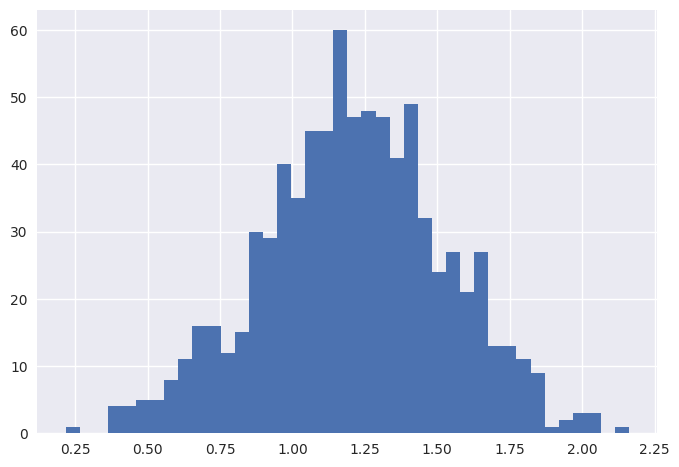

In [16]:
plt.hist(samples["beta"].detach().cpu(), bins=40)

(array([ 1.,  0.,  1.,  6.,  6.,  8.,  9., 20., 24., 16., 22., 30., 32.,
        41., 41., 45., 68., 55., 54., 53., 46., 43., 28., 46., 18., 25.,
        19.,  9., 16.,  6.,  1.,  4.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([1.76682186, 1.82365799, 1.88049424, 1.93733048, 1.99416661,
        2.05100274, 2.10783911, 2.16467524, 2.22151136, 2.27834749,
        2.33518362, 2.39201999, 2.44885612, 2.50569224, 2.56252861,
        2.61936474, 2.67620087, 2.73303699, 2.78987312, 2.84670949,
        2.90354562, 2.96038175, 3.01721811, 3.07405424, 3.13089037,
        3.1877265 , 3.24456263, 3.30139899, 3.35823512, 3.41507125,
        3.47190762, 3.52874374, 3.58557987, 3.642416  , 3.69925213,
        3.7560885 , 3.81292462, 3.86976075, 3.92659712, 3.98343325,
        4.04026937]),
 <BarContainer object of 40 artists>)

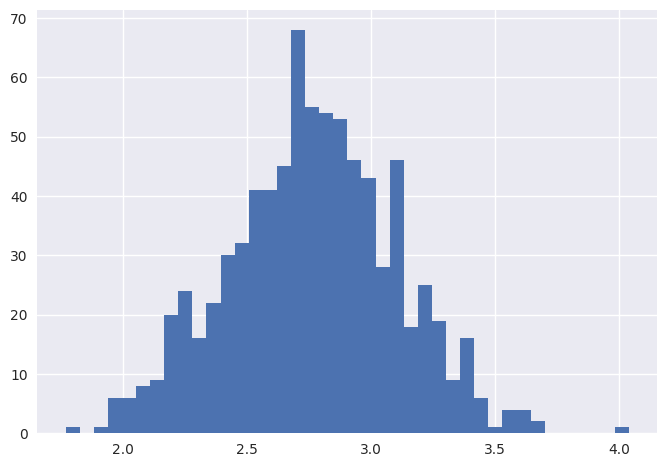

In [17]:
plt.hist(samples["c1"].detach().cpu(), bins=40)

(array([ 1.,  3.,  1.,  1.,  7.,  3.,  7.,  3., 13.,  9., 15., 16., 28.,
        21., 32., 45., 52., 48., 45., 47., 53., 47., 40., 45., 38., 37.,
        29., 24., 17., 17., 17., 14., 11.,  5.,  3.,  0.,  2.,  0.,  0.,
         4.]),
 array([-2.90286636, -2.86644292, -2.83001947, -2.79359603, -2.75717258,
        -2.72074914, -2.6843257 , -2.64790225, -2.61147881, -2.57505536,
        -2.53863192, -2.50220847, -2.46578503, -2.42936158, -2.39293814,
        -2.35651469, -2.32009125, -2.2836678 , -2.24724436, -2.21082091,
        -2.17439747, -2.13797402, -2.10155058, -2.06512713, -2.02870369,
        -1.99228024, -1.9558568 , -1.91943336, -1.88300991, -1.84658647,
        -1.81016302, -1.77373958, -1.73731613, -1.70089269, -1.66446924,
        -1.6280458 , -1.59162235, -1.55519891, -1.51877546, -1.48235202,
        -1.44592857]),
 <BarContainer object of 40 artists>)

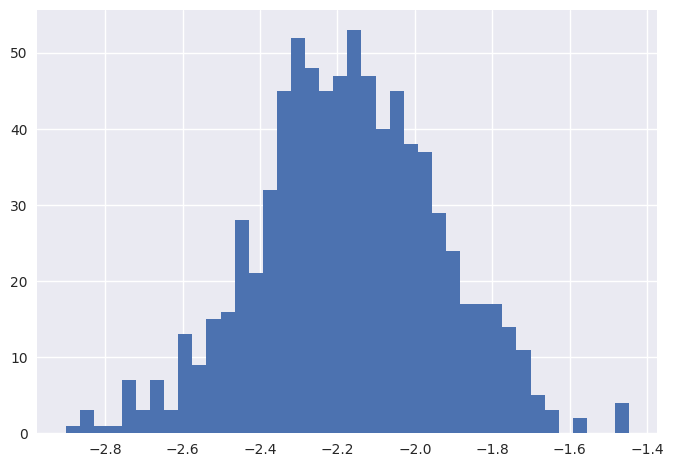

In [18]:
plt.hist(samples["c2"].detach().cpu(), bins=40)

In [19]:
predictive = infer.Predictive(model, guide=guide, num_samples=800)
svi_samples = predictive(x, flag, obs=None)
y_pred = svi_samples["obs"]

In [20]:
svi_samples.keys()

dict_keys(['beta', 'c1', 'c2', 'sigma', 'obs'])

In [21]:
y_pred.shape

torch.Size([800, 1000])

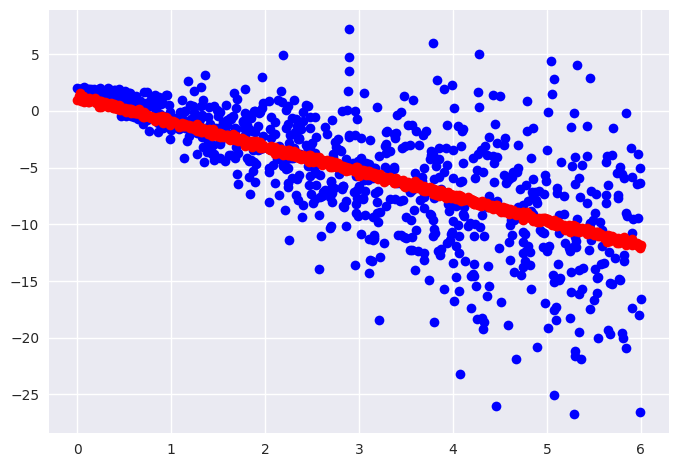

In [22]:
fig, ax = plt.subplots()
x_plot = x[flag == 0].numpy()
y_plot = y[flag == 0].numpy()
ypred_plot = y_pred.mean(axis=0)[flag == 0].numpy()
ax.plot(x_plot, y_plot, "bo")
ax.plot(x_plot, ypred_plot, "ro")

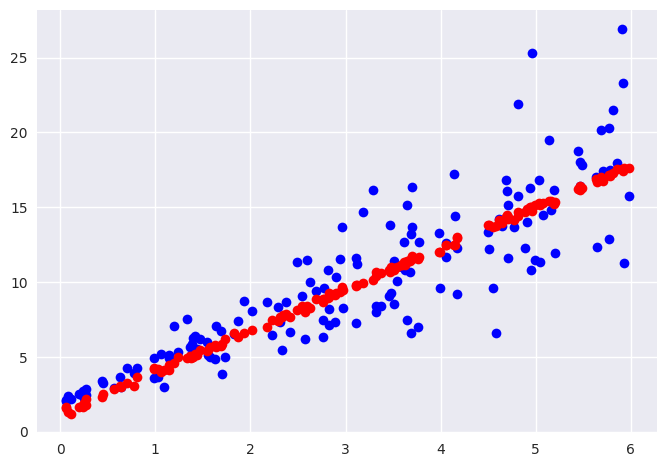

In [23]:
fig, ax = plt.subplots()
x_plot = x[flag == 1].numpy()
y_plot = y[flag == 1].numpy()
ypred_plot = y_pred.mean(axis=0)[flag == 1].numpy()
ax.plot(x_plot, y_plot, "bo")
ax.plot(x_plot, ypred_plot, "ro")

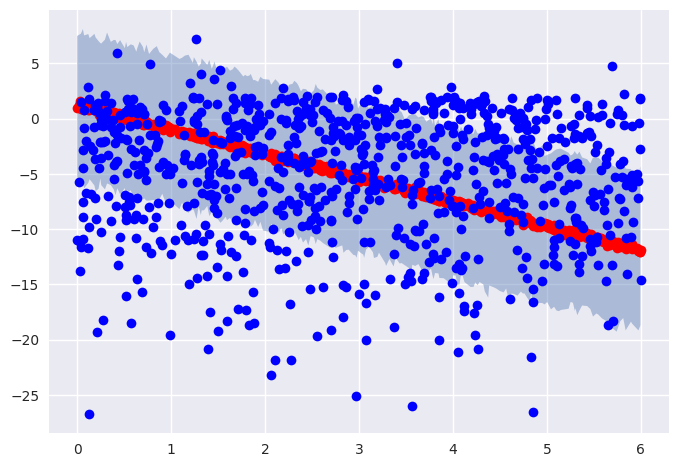

In [24]:
fig, ax = plt.subplots()
x_plot = x[flag == 0]
x_plot, x_indices = torch.sort(x_plot)
pred = y_pred[:, flag == 0]
pred = pred[:, x_indices]
ax.plot(x_plot, pred.mean(axis=0).numpy(), "ro")
ax.plot(x_plot, y[flag==0], "bo")
ax.fill_between(x_plot[::4], 
                pred.kthvalue(int(0.05 * pred.size(0)), 0).values[::4],
                pred.kthvalue(int(0.95 * pred.size(0)), 0).values[::4], 
                alpha=0.4
                )

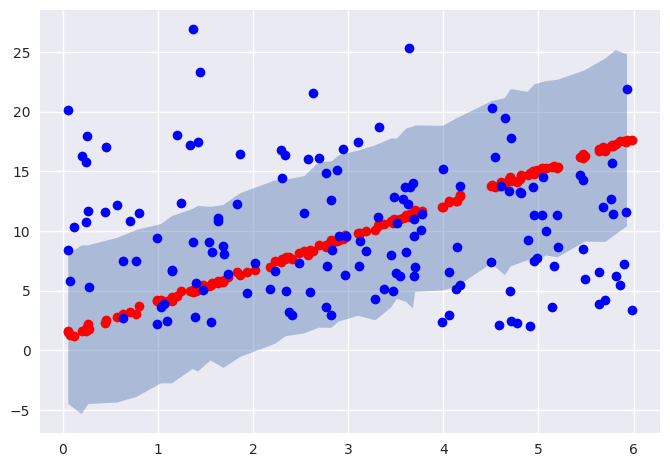

In [25]:
fig, ax = plt.subplots()
x_plot = x[flag == 1]
x_plot, x_indices = torch.sort(x_plot)
pred = y_pred[:, flag == 1]
pred = pred[:, x_indices]
ax.plot(x_plot, pred.mean(axis=0).numpy(), "ro")
ax.plot(x_plot, y[flag==1], "bo")
ax.fill_between(x_plot[::4], 
                pred.kthvalue(int(0.05 * pred.size(0)), 0).values[::4],
                pred.kthvalue(int(0.95 * pred.size(0)), 0).values[::4], 
                alpha=0.4
                )

In [26]:
from pyro.nn import PyroSample, PyroModule


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [27]:
model = BayesianRegression(2, 1)
guide = infer.autoguide.AutoDiagonalNormal(model)

In [28]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = infer.SVI(model, guide, adam, loss=infer.Trace_ELBO())

In [29]:
pyro.clear_param_store()
x_data = torch.column_stack((x, flag))
y_data = y.clone()
losses = []
for j in range(1000):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    losses.append(loss)

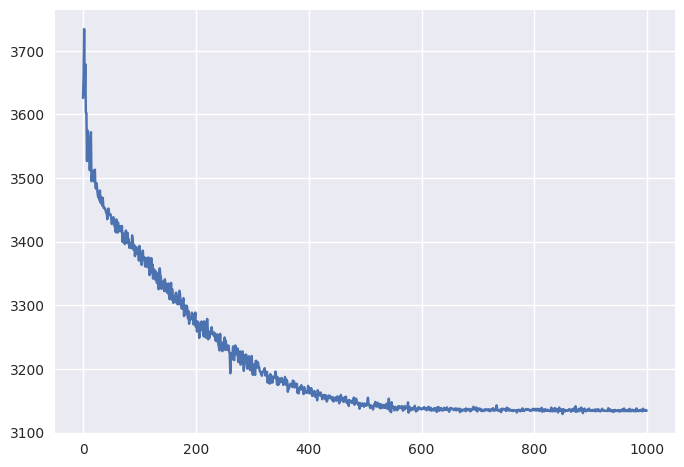

In [30]:
plt.plot(losses)

In [31]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 0.0529, -1.5578, 12.8526, -0.1889], requires_grad=True)
AutoDiagonalNormal.scale tensor([0.0497, 0.0523, 0.4143, 0.1903], grad_fn=<SoftplusBackward0>)


In [32]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 0.0529, -1.5578, 12.8526, -0.1889])
AutoDiagonalNormal.scale tensor([0.0497, 0.0523, 0.4143, 0.1903])


In [33]:
model.linear.weight

tensor([[0.7540, 0.4640]])

In [34]:
model.linear.weight

tensor([[0.1416, 0.8678]])

In [35]:
list(guide.parameters()) # weight, bias, sigma

[Parameter containing:
 tensor([ 0.0529, -1.5578, 12.8526, -0.1889]),
 Parameter containing:
 tensor([-2.9778, -2.9243, -0.6669, -1.5625])]

In [36]:
guide.quantiles([0.5])

{'sigma': tensor([5.1322]),
 'linear.weight': tensor([[[-1.5578, 12.8526]]]),
 'linear.bias': tensor([[-0.1889]])}

In [38]:
predictive = infer.Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)

In [39]:
samples["_RETURN"]

tensor([[-5.4229, -6.0025, -3.9355,  ..., -3.0001, -8.7950, 12.5344],
        [-5.2587, -5.8375, -3.7736,  ..., -2.8396, -8.6258, 12.3764],
        [-4.9302, -5.4918, -3.4890,  ..., -2.5826, -8.1975, 12.2327],
        ...,
        [-5.8289, -6.4248, -4.2996,  ..., -3.3377, -9.2961, 12.1263],
        [-5.3521, -5.9232, -3.8865,  ..., -2.9648, -8.6747, 12.2582],
        [-5.7306, -6.3358, -4.1776,  ..., -3.2009, -9.2515, 13.2183]])

In [40]:
samples["_RETURN"].size()

torch.Size([800, 1000])

In [42]:
samples["obs"].size(), x_data.size()

(torch.Size([800, 1000]), torch.Size([1000, 2]))

(-30.0, 30.0)

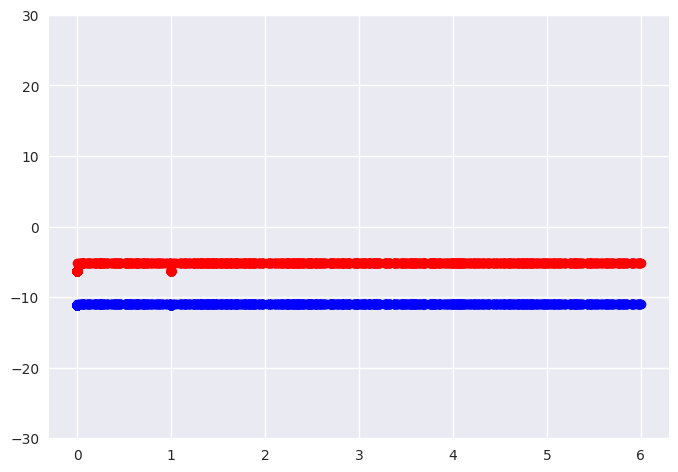

In [49]:
fig, ax = plt.subplots()
x_plot = x_data.clone()
x_plot, x_indices = torch.sort(x_plot)
pred = samples["obs"].clone()
pred = pred[:, x_indices]
ax.plot(x_plot, pred.mean(axis=0).numpy(), "ro")
ax.plot(x_plot, y[x_indices], "bo")
ax.set_ylim(-30, 30)